<a href="https://colab.research.google.com/github/Plumz17/PCD_FinalProject/blob/main/PCD_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Digital Image Processing Final Project - Group 5
* Anders Emmanuel Tan (24/541351/PA/22964) KOMB
* Evan Razzan Adytaputra (24/545257/PA/23166) KOMB
* Indratanaya Budiman (24/534784/PA/22683) KOMA
* Daffa Maulana Siddiq (24/533358/PA/22569) KOMA


## 1. Setting Up Image to be Processed (Image Acquisition)


In [2]:
#Cloning Github Repository to get the Image
!rm -rf PCD_FinalProject
!git clone https://github.com/Plumz17/PCD_FinalProject

Cloning into 'PCD_FinalProject'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 60 (delta 24), reused 4 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (60/60), 1.79 MiB | 11.00 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [3]:
#Upload Kaggle API to Download Dataset
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anderstan","key":"43202678ea8e16c0bfcf95862f9ace3b"}'}

In [4]:
#Download Dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset
!unzip tuberculosis-tb-chest-xray-dataset.zip -d TB_Dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 85% 563M/663M [00:03<00:01, 58.7MB/s]
100% 663M/663M [00:03<00:00, 195MB/s] 
Archive:  tuberculosis-tb-chest-xray-dataset.zip
  inflating: TB_Dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: TB_Dataset/TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: TB_Dataset/TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: TB_Dataset/TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: TB_Dataset/TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: TB_Dataset/TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: TB_Dataset/TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: TB_Dataset/TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: TB_Dataset/TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: TB_Dataset/TB_Chest_Radiography_

In [5]:
import cv2 # For Reading Image
import numpy as np # For Manipulating Image Matrix
import matplotlib.pyplot as plt # For Showing Image
import skimage #For Feature Extraction
from skimage import feature, img_as_ubyte # For LBP feature extraction
import math # For Math
import os #Access Folder


filename_normal = "/content/PCD_FinalProject/normal.png"
filename_tbc = "/content/PCD_FinalProject/tbc.png"

img_normal = cv2.imread(filename_normal) # Read Image
img_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2GRAY) # Change the color map

img_tbc = cv2.imread(filename_tbc) # Read Image
img_tbc = cv2.cvtColor(img_tbc, cv2.COLOR_BGR2GRAY) # Change the color map

In [6]:
def show_test(before, after, title1="TBC", title2="Normal"): # Helper function to check the before and after of the image processing (Only for the test)
  plt.figure(figsize=(10,5))

   # Show original
  plt.subplot(1,2,1)
  plt.imshow(before, cmap='gray', vmin=0, vmax=255) #vmin and max to preserve original image's contrast
  plt.title(title1)
  plt.axis("off")

  # Show processed
  plt.subplot(1,2,2)
  plt.imshow(after, cmap='gray', vmin=0, vmax=255)
  plt.title(title2)
  plt.axis("off")

  plt.show()

## 2. Image Enhancement


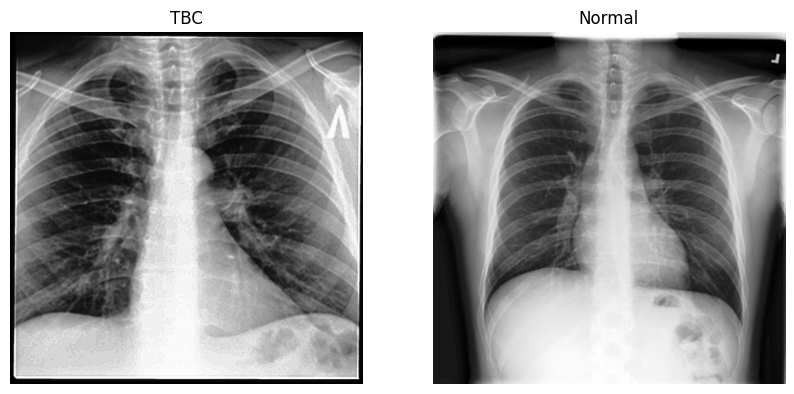

In [7]:
def enhance_image(img):
  #Apply Gaussian Smoothing with a kernel of 5x5
  img_gaussian = cv2.GaussianBlur(img, (5, 5), 0)
  #Additionally, Apply Laplacian Smoothing to highlight edge
  img_laplacian = cv2.Laplacian(img_gaussian, cv2.CV_64F)
  #Sharpen Image by adding the edges from Laplacian Smoothing
  img_sharpened = cv2.convertScaleAbs(img_gaussian - img_laplacian)
  #Apply Histogram Equilization to Increase the Image's Contrast
  img_hist = cv2.equalizeHist(img_sharpened)
  return img_hist

img_tbc_enhanced = enhance_image(img_tbc)
img_normal_enhanced = enhance_image(img_normal)
show_test(img_tbc_enhanced, img_normal_enhanced)

## 3. Image Segmentation


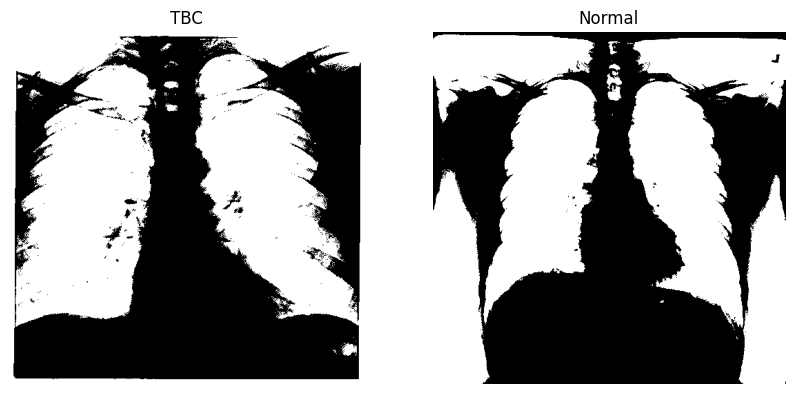

In [8]:
def segment_image(img):
  #Use Otsu Segmentation to Segment both Lungs
  ret, img = cv2.threshold(img, 0, 255,cv2.THRESH_OTSU)
  #Inverse the segmentation so we get the lungs as the foreground
  img = cv2.bitwise_not(img)
  return img

img_tbc_segmented = segment_image(img_tbc_enhanced)
img_normal_segmented = segment_image(img_normal_enhanced)

show_test(img_tbc_segmented, img_normal_segmented)

## 4. Morphological Processes

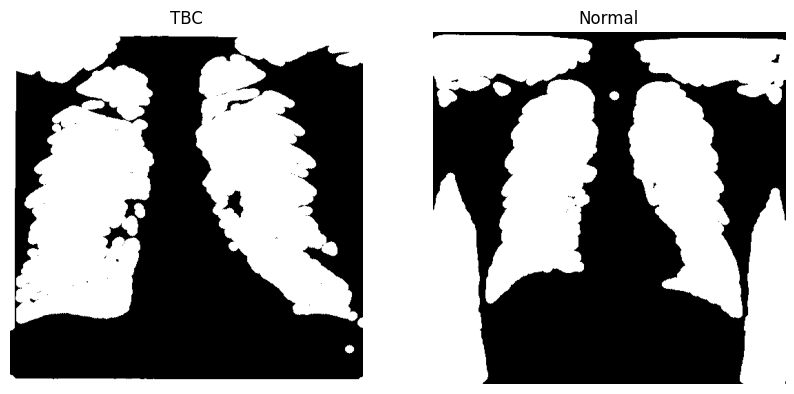

In [9]:
def morphological_process(img):
  #Create Elipse Kernel to use in the Opening Algorithm
  kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))

  #Execute Opening Algorithm to remove noise and seperate object
  img_normal_opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_opening)
  return img_normal_opened

img_tbc_opened = morphological_process(img_tbc_segmented)
img_normal_opened = morphological_process(img_normal_segmented)
show_test(img_tbc_opened, img_normal_opened)

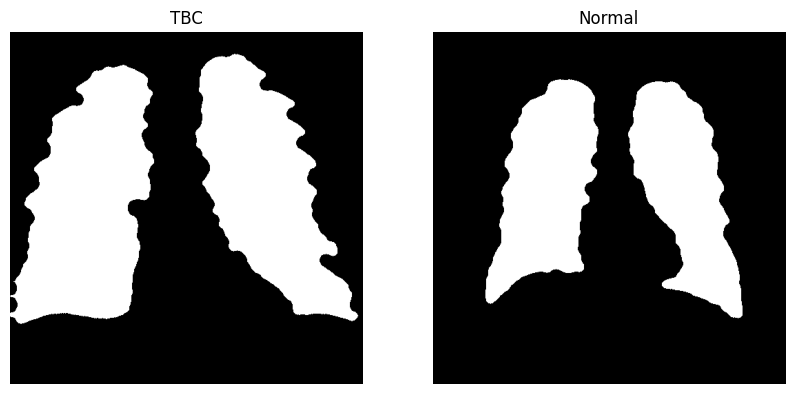

In [10]:
def select_lungs(segmented_image):
  # Find all connected components
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_image, 8, cv2.CV_32S)

  h, w = segmented_image.shape

  # The first component is usually the background, so we skip it.
  candidates = []
  for i in range(1, num_labels):
    x = centroids[i][0]
    y = centroids[i][1]
    area = stats[i, cv2.CC_STAT_AREA]

    # Lungs must be inside central region of the chest
    if w * 0.2 < x < w * 0.8:   # keep only components near the center
      candidates.append((area, i))

  #Sort by Area
  candidates.sort(key=lambda x: x[0], reverse=True)

  # Create blank images to hold the selected lungs
  lung1_image = np.zeros_like(segmented_image, dtype=np.uint8)
  lung2_image = np.zeros_like(segmented_image, dtype=np.uint8)

  # Select the two largest components (assuming they are the two lungs)
  if len(candidates) >= 1:
    largest_component_id = candidates[0][1]
    lung1_image[labels == largest_component_id] = 255
  if len(candidates) >= 2:
    second_largest_component_id = candidates[1][1]
    lung2_image[labels == second_largest_component_id] = 255

  return lung1_image, lung2_image

def get_mask(img):
  # Select lungs for TBC
  lung1, lung2 = select_lungs(img)
  lungs = cv2.add(lung1, lung2)

  #Create Elipse Kernel to use in the Closing Algorithm
  kernel_closing = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (19, 19))
  #Execute Closing Algorithm to fill in holes
  img = cv2.morphologyEx(lungs, cv2.MORPH_CLOSE, kernel_closing)
  return img

img_tbc_masked = get_mask(img_tbc_opened)
img_normal_masked = get_mask(img_normal_opened)

show_test(img_tbc_masked, img_normal_masked)

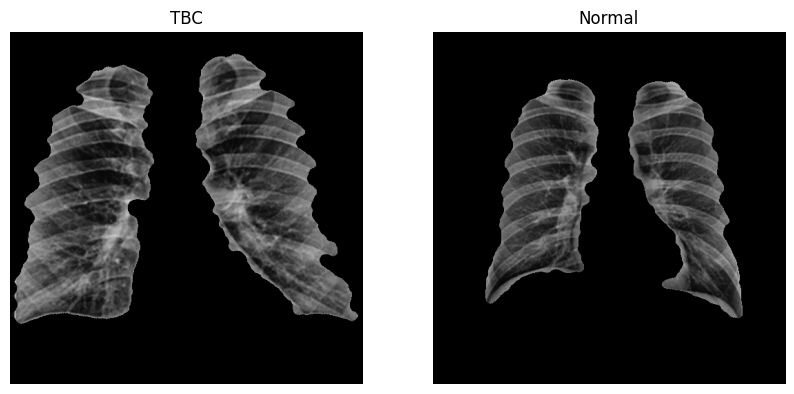

In [11]:
def apply_mask(img, mask):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

  # Apply CLAHE to the enhanced images
  img = clahe.apply(img)

  #Apply Mask using Bitwise And (The arguments are repeated since the function needs two arguments)
  img = cv2.bitwise_and(img, img, mask=mask)
  return img

tbc_masked = apply_mask(img_tbc_enhanced, img_tbc_masked)
normal_masked = apply_mask(img_normal_enhanced, img_normal_masked)
show_test(tbc_masked, normal_masked)

## 5. Feature Extraction and Representation

In [12]:
#Extract LBP Feature
def extract_lbp(image, P=8, R=1):
    lbp = feature.local_binary_pattern(image, P, R, method="uniform")
    # Histogram (59 bins for uniform LBP)
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype("float")
    hist /= hist.sum()  # normalize
    return hist

#Extract GLCM Feature
def extract_glcm(image):
  image = img_as_ubyte(image) #ensure image is in the correct format (graysclae 0-255)
  distances = [1, 2, 3] #takes texture from multiple spatial scales
  angles = [0, np.pi/4, np.pi/2, 3*np.pi/4] #devicne used angles since textures change depending on the direction
  glcm = feature.graycomatrix(image,
                              distances=distances,
                              angles=angles,
                              levels=256,
                              symmetric=True,
                              normed=True) #Computes GLCM
  features = []
  #Calculate these Haralick features (might add/remove some later)
  props = ['ASM', 'variance', 'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'entropy']

  for prop in props: #Extract Values for each property
    values = feature.graycoprops(glcm, prop).flatten()
    features.extend(values)

  return np.array(features) #Return as an numpy array

#Extract HOG Features
def extract_hog(image):
  #Calculated Histogram of Oriented Gradients
  hog = skimage.feature.hog(image, orientations=9,
                            pixels_per_cell=(8, 8),
                            cells_per_block=(2,2),
                            block_norm='L2-Hys',
                            transform_sqrt = True,
                            feature_vector=True)
  return hog

#Use all prev functions to get the final vector
def extract_features(image):
  lbp_features = extract_lbp(image)
  glcm_features = extract_glcm(image)
  hog_features = extract_hog(image)

  final_vector = np.concatenate((lbp_features, glcm_features, hog_features)) #Combine the vectors
  return final_vector

tbc_features = extract_features(tbc_masked)
normal_features = extract_features(normal_masked)
print(f"TBC Features: {tbc_features.shape}")
print(f"Normal Features: {normal_features.shape}")


TBC Features: (142990,)
Normal Features: (142990,)


##6. Image Processing

In [13]:
def process_image(img):
  #Image Acquisition
  if len(img.shape) == 3: #Check if already Grayscale, might remove later
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #Image Enhancement
  img_enhanced = enhance_image(img)
  #Image Segmentation
  img = segment_image(img_enhanced)
  #Morphological Processes
  img = morphological_process(img)
  #Getting andApplying Mask
  img = get_mask(img)
  img = apply_mask(img_enhanced, img)
  return img

def process_and_get_vector(img):
  img = process_image(img)
  return extract_features(img)

img_test = process_image(img_tbc)
img_test2 = process_image(img_normal)
print(f"TBC Features: {process_and_get_vector(img_tbc)}")
print(f"Normal Features: {process_and_get_vector(img_normal)}")

TBC Features: [0.03556442 0.03373337 0.02246475 ... 0.         0.         0.        ]
Normal Features: [0.01786423 0.01780319 0.01591492 ... 0.         0.         0.        ]


## 7. Image Processing

In [ ]:
#This part is just for testing
import os

#Set File Location
normal_dir = '/content/TB_Dataset/TB_Chest_Radiography_Database/Normal'
tbc_dir = '/content/TB_Dataset/TB_Chest_Radiography_Database/Tuberculosis'

#Set Features and Labels to be trained
X = []   # feature vectors
y = []   # labels (0 = normal, 1 = TB)

# Verify whether the directories exists
print(f"Normal directory exists: {os.path.isdir(normal_dir)}")
print(f"Tuberculosis directory exists: {os.path.isdir(tbc_dir)}")

#Preprocess images
def process_folder(folder_path, label):
  #Get all image files
  image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
  total = len(image_files)
  print(f"Found {total} images in {folder_path}.")

  #Process every image in a specific directory
  for i, filename in enumerate(image_files, start=1):
    image_path = os.path.join(normal_dir, filename)
    img = cv2.imread(image_path)
    if img is None:
      print(f"Warning: Could not read image {image_path}")
      continue
    features = process_and_get_vector(img)
    X.append(features)
    y.append(label)
    print(f"Processed {filename}  ({i}/{total})")

#Process both folders
process_folder(normal_dir, label=0)
process_folder(tbc_dir, label=1)

#Convert result to numpy array
X = np.array(X)
y = np.array(y)


Normal directory exists: True
Tuberculosis directory exists: True
Found 3500 images in /content/TB_Dataset/TB_Chest_Radiography_Database/Normal.
Processed Normal-2533.png  (1/3500)
Processed Normal-2363.png  (2/3500)
Processed Normal-1678.png  (3/3500)
Processed Normal-115.png  (4/3500)
Processed Normal-1258.png  (5/3500)
Processed Normal-3465.png  (6/3500)
Processed Normal-1876.png  (7/3500)
Processed Normal-2283.png  (8/3500)
Processed Normal-747.png  (9/3500)
Processed Normal-1280.png  (10/3500)
Processed Normal-3267.png  (11/3500)
Processed Normal-2061.png  (12/3500)
Processed Normal-3075.png  (13/3500)
Processed Normal-1103.png  (14/3500)
Processed Normal-2656.png  (15/3500)
Processed Normal-1395.png  (16/3500)
Processed Normal-36.png  (17/3500)
Processed Normal-1147.png  (18/3500)
Processed Normal-2204.png  (19/3500)
Processed Normal-865.png  (20/3500)
Processed Normal-3245.png  (21/3500)
Processed Normal-1371.png  (22/3500)
Processed Normal-3224.png  (23/3500)
Processed Normal-5